# Variational inference using the finite approximation

In [19]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [20]:
np.random.seed(12321) # this is a seed where VI works well

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf)
# A = np.array([[10,10], [-10,10]])

# draw noise
epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]]


# set initializations

In [21]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}


# run CAVI

In [ ]:
for i in range(iterations):
    iter_ran = i + 1
    nu_updates(tau, nu, phi_mu, phi_var, X, sigmas, Data_shape)

    phi_updates(nu, phi_mu, phi_var, X, sigmas, Data_shape)
        
    tau_updates(tau, nu, alpha, Data_shape)    
    
    
    
    round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)
    
    [elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],elbo_Term7[i]] \
        = Elbo(tau, nu, phi_mu, phi_var, X, sigmas, Data_shape, alpha)
        
    
    print('iteration: ', i)
    print('elbo: ', elbo[i])
    #print(round_nu[0:10,:])
    #print(nu[0:10,:])
    print('l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]) )
    
    if (i>0) & (elbo[i] < elbo[i-1]): 
        print('eblo decreased!')
        break
    
    if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8):
        break
    

iteration:  0
elbo:  -59592.2483785
l1 error:  0.455919388579
iteration:  1
elbo:  -20464.6869536
l1 error:  0.40545832501


C:\Users\Haiying Liang\Desktop\BNP\Variational_BNP_robustness\Finite_approx\valez_finite_VI_lib.py:85: RuntimeWarning: overflow encountered in exp
  nu[n,k] = 1./(1.+np.exp(-script_V))


iteration:  2
elbo:  -16849.0766319
l1 error:  0.436667676047
iteration:  3
elbo:  -15067.3912309
l1 error:  0.438828701105
iteration:  4
elbo:  -13550.9842664
l1 error:  0.443122718242
iteration:  5
elbo:  -12243.8876513
l1 error:  0.447999990912
iteration:  6
elbo:  -11577.1630071
l1 error:  0.448
iteration:  7
elbo:  -11211.34179
l1 error:  0.448000000673
iteration:  8
elbo:  -10963.2650067
l1 error:  0.448969592354
iteration:  9
elbo:  -10337.5069778
l1 error:  0.455106540939
iteration:  10
elbo:  -9831.56485025
l1 error:  0.456000012816
iteration:  11
elbo:  -9506.11677966
l1 error:  0.456666666667
iteration:  12
elbo:  -9338.94439233
l1 error:  0.456666666667
iteration:  13
elbo:  -9231.11678672
l1 error:  0.456666666667
iteration:  14
elbo:  -9161.56707653
l1 error:  0.456666666667
iteration:  15
elbo:  -9116.70693
l1 error:  0.456666666667
iteration:  16
elbo:  -9087.77175914
l1 error:  0.456666666667
iteration:  17
elbo:  -9069.1083312
l1 error:  0.456666666667
iteration:  18


Z 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]]
round_nu 
 [[ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]]
error in row 1:  0.72
error in row 2:  0.306
error in row 3:  0.344


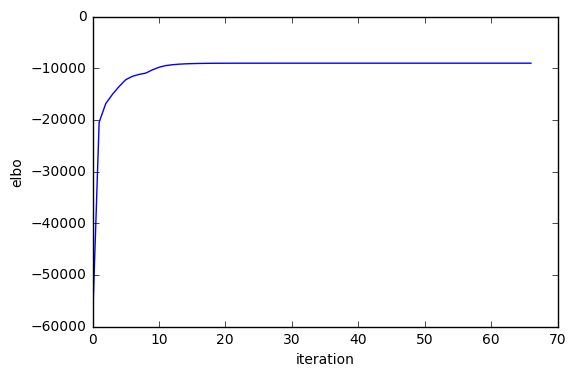

In [15]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
print('Z \n', Z[0:10,:])
print('round_nu \n', round_nu[0:10,:])

print('error in row 1: ', np.sum(np.abs(Z[:,0] - nu[:,0]))/Num_samples)
print('error in row 2: ', np.sum(np.abs(Z[:,1] - nu[:,1]))/Num_samples)
print('error in row 3: ', np.sum(np.abs(Z[:,2] - nu[:,2]))/Num_samples)


plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

In [18]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

4.42912421833e-180
1.54075195072e-82
0.614
